In [1]:
!pip install joypy
!pip install cityscapesscripts
!pip install qai-hub-models

In [2]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Benchmarking

## Model Interface Requirements

To benchmark a new model, you need to wrap it in a class that follows this interface:

1.  **Input**: The `predict` method must accept a `PIL.Image.Image` in RGB mode.
2.  **Output**: The `predict` method must return a `numpy.ndarray` of shape `(Height, Width)` with integer type (e.g., `uint8` or `int64`).
    *   The values in the array should be the **trainIds** (0-18 for Cityscapes classes).
    *   Pixels to be ignored should be marked with `255` (or whatever your ignore index is, usually 255).

### Example Base Class Structure

```python
from abc import ABC, abstractmethod
import numpy as np
from PIL import Image

class BaseSegmentationModel(ABC):
    @abstractmethod
    def predict(self, image: Image.Image) -> np.ndarray:
        """
        Args:
            image (PIL.Image.Image): Input image (RGB).
        Returns:
            np.ndarray: Segmentation mask (H, W) with integer trainIds.
        """
        pass
```

In [3]:
# --- Step 1: Define General Model Interface & Setup SegFormer Example ---

from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict
from abc import ABC, abstractmethod

import numpy as np
from PIL import Image
import torch

# Cityscapes label definitions
from cityscapesscripts.helpers.labels import labels as CS_LABELS

# -----------------------------------------------------------------------------
# 1. Abstract Base Class for Segmentation Models
# -----------------------------------------------------------------------------
class BaseSegmentationModel(ABC):
    @abstractmethod
    def predict(self, image: Image.Image) -> np.ndarray:
        """
        Run inference on a single image.

        Args:
            image (PIL.Image.Image): Input image in RGB mode.

        Returns:
            np.ndarray: Predicted segmentation mask of shape (H, W).
                        Values should be integer trainIds (0-18).
        """
        pass

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
import os

# -----------------------------------------------------------------------------
# 2. Concrete Implementation: DDRNet23_Slim Wrapper (using qai_hub_models)
# -----------------------------------------------------------------------------
from qai_hub_models.models.ddrnet23_slim import Model

class DDRNetWrapper(BaseSegmentationModel):
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Loading DDRNet23-Slim from qai_hub_models...")

        # Load the pre-trained model from Qualcomm AI Hub
        # The returned object is a CityscapesSegmentor wrapper which has a bug with device placement
        # in its forward method (normalization constants are always on CPU).
        # We will extract the inner model and handle normalization ourselves.
        wrapper = Model.from_pretrained()
        self.model = wrapper.model
        self.model.to(self.device)
        self.model.eval()

        # Standard ImageNet normalization
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)

    def predict(self, image: Image.Image) -> np.ndarray:
        original_size = image.size # (W, H)

        # DDRNet requires input dimensions to be multiples of 32
        # to ensure feature map alignment in dual branches.
        w, h = original_size
        new_w = ((w + 31) // 32) * 32
        new_h = ((h + 31) // 32) * 32

        input_image = image
        if new_w != w or new_h != h:
            # Use BILINEAR for resizing
            input_image = image.resize((new_w, new_h), Image.BILINEAR)

        # Preprocess
        img_tensor = transforms.ToTensor()(input_image).unsqueeze(0).to(self.device)
        img_tensor = (img_tensor - self.mean) / self.std

        with torch.no_grad():
            output = self.model(img_tensor)

            # Handle potential list/tuple output
            if isinstance(output, (list, tuple)):
                output = output[0]

            # Resize back to original size
            if output.shape[-2:] != (original_size[1], original_size[0]):
                output = F.interpolate(output, size=(original_size[1], original_size[0]), mode='bilinear', align_corners=True)

            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        return pred.astype(np.uint8)

# Instantiate the model we want to test
current_model = DDRNetWrapper()

Loading DDRNet23-Slim from qai_hub_models...


In [20]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTL0o6GE2daUNcY6klb5kboC3FMcWzTw8aq4w&s"
image = Image.open(requests.get(url, stream=True).raw)

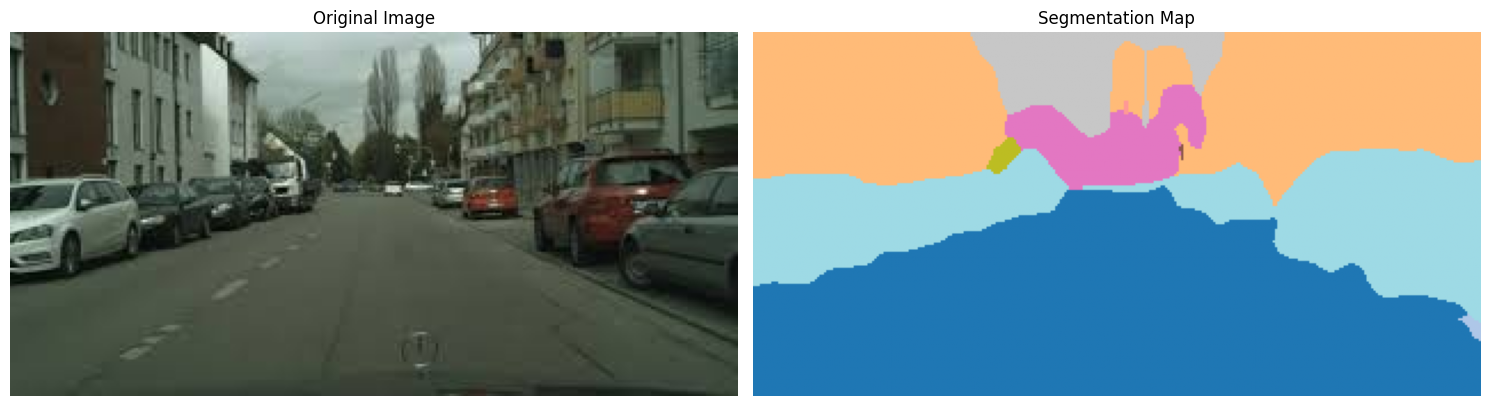

In [22]:
pred_seg = current_model.predict(image)
def visualize_segmentation(original_image, segmentation_map):
    plt.figure(figsize=(15, 5))

    # Plot Original
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Plot Segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(segmentation_map, cmap='tab20') # 'tab20' gives distinct colors
    plt.title("Segmentation Map")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_segmentation(image, pred_seg)

In [23]:
@dataclass
class LabelSpec:
    name: str            # "road"
    group: str           # "flat"
    id: int              # Cityscapes labelId
    train_id: int        # Cityscapes trainId (0-18, 255 = ignore)
    ignore_in_eval: bool # True for '+' labels / void classes

def build_cityscapes_label_specs() -> Dict[str, LabelSpec]:
    specs: Dict[str, LabelSpec] = {}
    for lab in CS_LABELS:
        specs[lab.name] = LabelSpec(
            name=lab.name,
            group=lab.category,
            id=lab.id,
            train_id=lab.trainId,
            ignore_in_eval=lab.ignoreInEval,
        )
    return specs

CITYSCAPES_LABEL_SPECS: Dict[str, LabelSpec] = build_cityscapes_label_specs()

# Map raw labelId -> trainId (255 for ignore)
CITYSCAPES_ID2TRAINID: Dict[int, int] = {}
for spec in CITYSCAPES_LABEL_SPECS.values():
    tid = spec.train_id
    if tid < 0:
        tid = 255
    CITYSCAPES_ID2TRAINID[spec.id] = tid

# Official 19 evaluation classes
CITYSCAPES_EVAL_TRAIN_IDS: List[int] = sorted(
    {
        spec.train_id
        for spec in CITYSCAPES_LABEL_SPECS.values()
        if spec.train_id >= 0 and not spec.ignore_in_eval
    }
)

CITYSCAPES_TRAINID2NAME: Dict[int, str] = {
    spec.train_id: spec.name
    for spec in CITYSCAPES_LABEL_SPECS.values()
    if spec.train_id in CITYSCAPES_EVAL_TRAIN_IDS
}

CITYSCAPES_NUM_CLASSES: int = 256
CITYSCAPES_IGNORE_INDEX: int = 255

In [24]:
# If your dataset is on Drive, mount and point ROOT there
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [25]:
from pathlib import Path
# CITYSCAPES_ROOT = Path("/content/drive/MyDrive/cityscapes")
CITYSCAPES_ROOT = Path("/content/drive/MyDrive/UCLA/Datasets/cityscapes")

In [26]:

# --- Step 2: Load Cityscapes val split paths in Colab ---

def list_cityscapes_split(root: Path, split: str = "val"):
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    image_paths = sorted(img_dir.rglob("*_leftImg8bit.png"))
    print(f"Found {len(image_paths)} images in split='{split}'")
    return image_paths, gt_dir

val_image_paths, val_gt_dir = list_cityscapes_split(CITYSCAPES_ROOT, split="val")


Found 500 images in split='val'


In [27]:
# --- Step 3: Build a parseable representation (DataFrame) for val ---

import pandas as pd

def make_cityscapes_dataframe(root: Path, split: str = "val") -> pd.DataFrame:
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    records = []
    for img_path in sorted(img_dir.rglob("*_leftImg8bit.png")):
        city = img_path.parent.name
        stem = img_path.name.replace("_leftImg8bit.png", "")

        label_ids = gt_dir / city / f"{stem}_gtFine_labelIds.png"
        instance_ids = gt_dir / city / f"{stem}_gtFine_instanceIds.png"
        color_png = gt_dir / city / f"{stem}_gtFine_color.png"
        polygons_json = gt_dir / city / f"{stem}_gtFine_polygons.json"

        records.append(
            {
                "city": city,
                "image_id": stem,
                "image_path": str(img_path),
                "labelIds_path": str(label_ids),
                "instanceIds_path": str(instance_ids),
                "color_path": str(color_png),
                "polygons_path": str(polygons_json),
            }
        )

    df = pd.DataFrame.from_records(records)
    return df


val_df = make_cityscapes_dataframe(CITYSCAPES_ROOT, split="val")
print("Total val samples:", len(val_df))
display(val_df.head())


Total val samples: 500


,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [38]:
# --- Step 4: Run Inference using the General Model Interface ---

from tqdm.auto import tqdm
import numpy as np

# Define where to save predictions for the current model
# We use the class name to distinguish different models
model_dir_name = current_model.__class__.__name__.replace("Wrapper", "") + "_preds"
PRED_ROOT = CITYSCAPES_ROOT / model_dir_name / "val"
PRED_ROOT.mkdir(parents=True, exist_ok=True)


def run_inference_over_df(
    df: pd.DataFrame,
    model: BaseSegmentationModel,
    pred_root: Path,
    overwrite: bool = False,
) -> pd.DataFrame:
    """
    Generic inference loop using BaseSegmentationModel.

    Args:
        df: DataFrame containing image paths.
        model: Instance of BaseSegmentationModel.
        pred_root: Directory to save .npy predictions.
        overwrite: If True, re-run inference even if file exists.
    """
    df = df.copy()
    pred_paths = []

    print(f"Running inference with {model.__class__.__name__}...")
    print(f"Saving results to: {pred_root}")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = Path(row["image_path"])
        image_id = row["image_id"]

        # We'll save as {image_id}_trainIds.npy
        out_path = pred_root / f"{image_id}_trainIds.npy"

        if out_path.exists() and not overwrite:
            pred_paths.append(str(out_path))
            continue

        # Load Image
        img = Image.open(img_path).convert("RGB")

        # Predict using the abstract interface
        pred_trainids = model.predict(img)

        # Save
        np.save(out_path, pred_trainids)
        pred_paths.append(str(out_path))

    df["pred_trainIds_path"] = pred_paths
    return df


# Run inference with the instantiated 'current_model'
val_df_pred = run_inference_over_df(
    val_df,
    model=current_model,
    pred_root=PRED_ROOT,
    overwrite=False,
)

display(val_df_pred.head())

Running inference with DDRNetWrapper...
Saving results to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/DDRNet_preds/val


  0%|          | 0/500 [00:00<?, ?it/s]

,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path,pred_trainIds_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [39]:
def iou_from_confusion(cm: np.ndarray) -> np.ndarray:
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    return intersection / np.maximum(union, 1)

def evaluate_and_collect(df):
    global_cm = np.zeros((CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES), dtype=np.int64)
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        # load GT + pred
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt = labelIds_to_trainIds_fast(gt)
        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred = np.clip(pred, 0, CITYSCAPES_NUM_CLASSES - 1)

        # mask + flatten
        mask = gt != CITYSCAPES_IGNORE_INDEX
        gt_f = gt[mask].astype(np.int64) # Cast gt_f to int64
        pred_f = pred[mask].astype(np.int64) # Cast pred_f to int64

        idx = np.int64(CITYSCAPES_NUM_CLASSES) * gt_f + pred_f

        # per-image CM
        cm = np.bincount(idx, minlength=CITYSCAPES_NUM_CLASSES**2).reshape(
            CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES
        )

        # add to global CM
        global_cm += cm

        # per-image IoU
        inter = np.diag(cm)
        union = cm.sum(0) + cm.sum(1) - inter
        iou = np.where(union > 0, inter/union, np.nan)

        entry = {
            "image_id": row["image_id"],
            "city": row["city"],
        }
        for tid in CITYSCAPES_EVAL_TRAIN_IDS:
            entry[CITYSCAPES_TRAINID2NAME[tid]] = iou[tid]

        rows.append(entry)

    return global_cm, pd.DataFrame(rows)

In [40]:
lut = np.full(256, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
for raw, tid in CITYSCAPES_ID2TRAINID.items():
    lut[raw] = np.uint8(tid)

def labelIds_to_trainIds_fast(label_ids: np.ndarray) -> np.ndarray:
    return lut[label_ids]


# ===============================================
# Fast confusion matrix calculation
# ===============================================
def confusion_matrix_from_df_fast(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # ---- Preload all GTs & predictions to avoid slow disk I/O ----
    gt_list = []
    pred_list = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Loading GT + predictions"):
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt_list.append(labelIds_to_trainIds_fast(gt))

        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred_list.append(np.clip(pred, 0, num_classes - 1))

    # ---- Compute confusion matrix in vectorized form ----
    for gt_train, pred_train in tqdm(zip(gt_list, pred_list), total=len(gt_list),
                                     desc="Computing confusion matrix"):

        mask = gt_train != ignore_index

        gt_flat = gt_train[mask].astype(np.int64)
        pred_flat = pred_train[mask].astype(np.int64)

        idx = num_classes * gt_flat + pred_flat

        cm += np.bincount(
            idx,
            minlength=num_classes * num_classes,
        ).reshape(num_classes, num_classes)

    return cm

The next two blocks are for speed improvements

In [41]:
!rsync -ah --info=progress2 /content/drive/MyDrive/cityscapes/ /content/cityscapes_local/

rsync: [sender] change_dir "/content/drive/MyDrive/cityscapes" failed: No such file or directory (2)
              0 100%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/0)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


In [42]:
val_df_pred["labelIds_path"] = val_df_pred["labelIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

val_df_pred["pred_trainIds_path"] = val_df_pred["pred_trainIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

In [43]:
global_cm, per_image_iou_df = evaluate_and_collect(val_df_pred)
ious = iou_from_confusion(global_cm)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2253135274.py:35: RuntimeWarning: invalid value encountered in divide
  iou = np.where(union > 0, inter/union, np.nan)


In [44]:
per_image_iou_df

,image_id,city,road,sidewalk,building,wall,fence,pole,traffic light,traffic sign,...,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
0,frankfurt_000000_000294,frankfurt,0.985402,0.929669,0.969397,NaN,0.000000,0.651045,0.000000,0.794332,...,0.000000,0.943828,0.829562,NaN,0.961231,NaN,NaN,NaN,NaN,NaN
1,frankfurt_000000_000576,frankfurt,0.993062,0.941822,0.968607,NaN,0.855656,0.510269,0.000000,0.681759,...,0.000000,0.962415,0.000000,0.671291,0.972680,NaN,NaN,NaN,NaN,0.645323
2,frankfurt_000000_001016,frankfurt,0.963752,0.543212,0.988149,0.000000,0.000000,0.566498,NaN,0.844996,...,NaN,NaN,0.865776,0.821732,0.946618,NaN,NaN,NaN,NaN,0.675266
3,frankfurt_000000_001236,frankfurt,0.988599,0.650442,0.726595,NaN,0.769924,0.507102,0.511227,0.690384,...,0.000000,0.947986,0.642012,0.000000,0.963554,0.000000,NaN,NaN,NaN,0.421663
4,frankfurt_000000_001751,frankfurt,0.990411,0.846175,0.942571,NaN,NaN,0.329175,0.531646,0.627366,...,NaN,0.969628,0.343042,0.569289,0.963908,0.000000,NaN,NaN,NaN,0.507751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,munster_000169_000019,munster,0.993981,0.856214,0.891630,0.000000,0.000000,0.522479,0.773469,0.855720,...,0.000000,0.965337,0.503526,0.490009,0.885301,0.000000,NaN,NaN,NaN,0.618637
496,munster_000170_000019,munster,0.993073,NaN,0.187297,NaN,NaN,0.490436,0.511265,0.802313,...,NaN,0.910528,0.011673,0.321678,0.942288,NaN,NaN,NaN,NaN,0.147090
497,munster_000171_000019,munster,0.994003,0.911566,0.509858,0.000000,0.413815,0.501820,0.000000,0.253363,...,0.783987,0.971243,0.280906,0.508705,0.962290,0.505221,0.918074,NaN,NaN,0.434604
498,munster_000172_000019,munster,0.986307,0.320031,0.942415,0.000000,0.000000,0.573791,NaN,0.718453,...,0.831052,0.977834,0.592771,NaN,0.977198,NaN,NaN,NaN,NaN,0.428734


In [45]:
print("Per-class IoU (Cityscapes 19 eval classes):")
for tid in CITYSCAPES_EVAL_TRAIN_IDS:
    name = CITYSCAPES_TRAINID2NAME[tid]
    print(f"{tid:2d} {name:>12s}: {ious[tid] * 100:5.2f}%")

miou = np.mean([ious[tid] for tid in CITYSCAPES_EVAL_TRAIN_IDS])
print(f"\nMean IoU over {len(CITYSCAPES_EVAL_TRAIN_IDS)} classes: {miou * 100:5.2f}%")

Per-class IoU (Cityscapes 19 eval classes):
 0         road: 97.99%
 1     sidewalk: 84.08%
 2     building: 91.73%
 3         wall: 51.33%
 4        fence: 61.48%
 5         pole: 58.11%
 6 traffic light: 67.96%
 7 traffic sign: 75.20%
 8   vegetation: 91.98%
 9      terrain: 66.00%
10          sky: 93.71%
11       person: 79.86%
12        rider: 62.19%
13          car: 94.57%
14        truck: 79.55%
15          bus: 87.84%
16        train: 80.98%
17   motorcycle: 59.68%
18      bicycle: 75.53%

Mean IoU over 19 classes: 76.83%


In [46]:
import joypy
import matplotlib.pyplot as plt
import numpy as np

# Identify class columns
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

# Sort by class difficulty (median IoU)
median_iou = per_image_iou_df[class_cols].median().sort_values()
sorted_classes = median_iou.index.tolist()

# Build clean data: each class has its own filtered 1D array
clean_data = {}
for cls in sorted_classes:
    col = per_image_iou_df[cls]
    # convert strings or invalid entries to NaN
    col = pd.to_numeric(col, errors='coerce')
    # remove NaNs (meaning class absent)
    col = col.dropna()
    clean_data[cls] = col.values

In [47]:
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

long_df = (
    per_image_iou_df[class_cols]
    .melt(var_name='category', value_name='IoU')
    .dropna()
)

# drop NaNs (class not present in image) )
plot_df = long_df[long_df["IoU"] > 0]


<Figure size 1000x1200 with 0 Axes>

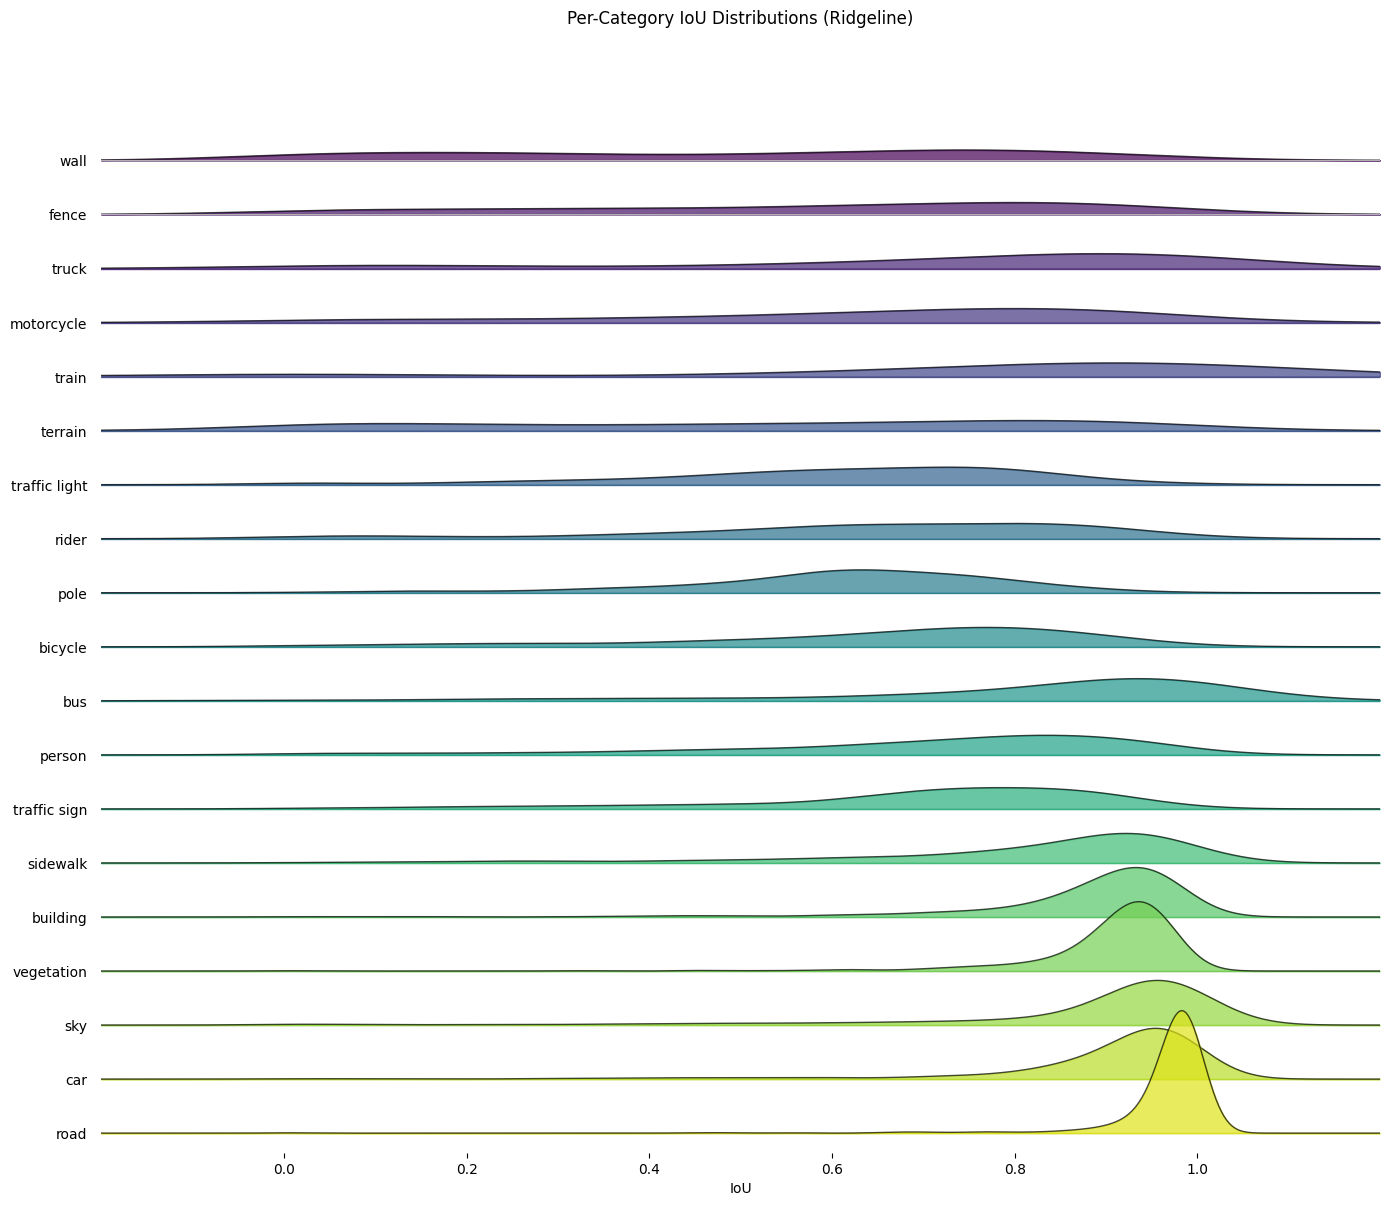

In [48]:
import joypy
import matplotlib.pyplot as plt

# Pivot long_df back to wide form for joypy
pivot_df = plot_df.pivot(columns='category', values='IoU')
norm_df = pivot_df.apply(lambda s: (s - s.min()) / (s.max() - s.min()))

plt.figure(figsize=(10, 12))
joypy.joyplot(
    data=norm_df,
    column=sorted_classes,
    labels=sorted_classes,
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(14, 12),
    title="Distribution of Per-Image IoU by Class (NaNs removed correctly)",
    colormap=plt.cm.viridis,
    alpha=0.7,
    overlap=1.4,
)
# joypy.joyplot(
#     pivot_df,
#     column=sorted_classes,
#     labels=sorted_classes,
#     kind="kde",
#     range_style="own",
#     bw_method=0.3,     # ← try values 0.1–0.3 for smoothness
#     linewidth=1,
#     colormap=plt.cm.viridis,
#     overlap=1.4,
# )
plt.title("Per-Category IoU Distributions (Ridgeline)")
plt.xlabel("IoU")
plt.show()


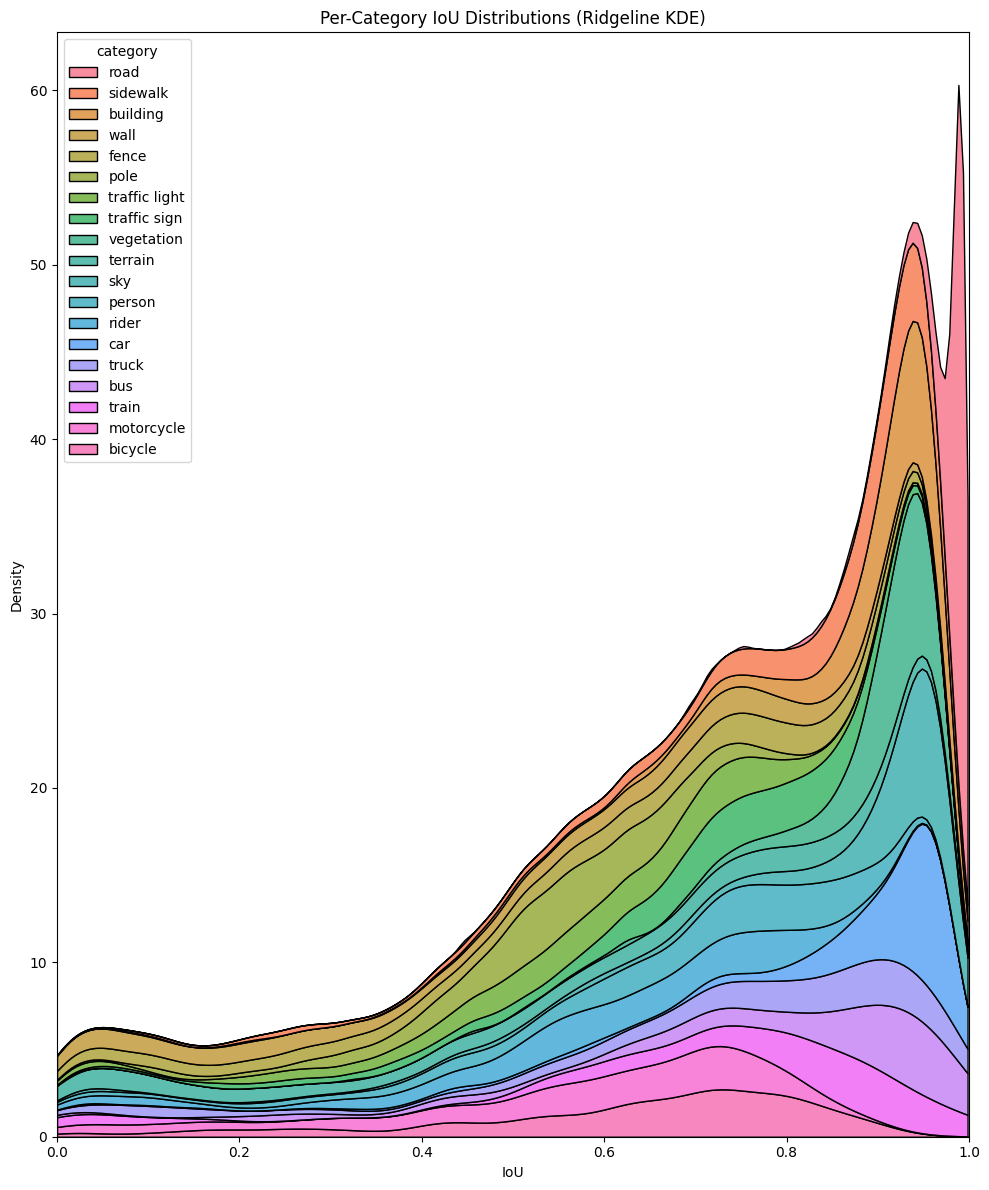

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

sns.kdeplot(
    data=plot_df,
    x="IoU",
    hue="category",
    fill=True,
    alpha=0.8,
    linewidth=1,
    multiple="stack",
    common_norm=False,
    bw_adjust=0.5,
    cut=0
)

plt.xlim(0, 1)
plt.title("Per-Category IoU Distributions (Ridgeline KDE)")
plt.xlabel("IoU")
plt.tight_layout()
plt.show()


# Save Results for Comparative Analysis

In [50]:
# Construct a filename based on the model class name
model_name = current_model.__class__.__name__
csv_filename = f"{model_name}_per_image_iou.csv"
save_path = CITYSCAPES_ROOT / "benchmark_results" / csv_filename

# Ensure directory exists
save_path.parent.mkdir(parents=True, exist_ok=True)

# Save
per_image_iou_df.to_csv(save_path, index=False)
print(f"Saved per-image IoU stats to: {save_path}")

Saved per-image IoU stats to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/benchmark_results/DDRNetWrapper_per_image_iou.csv
